In [ ]:
import numpy as np
import scipy.signal
import hfda
from petastorm import make_reader
import matplotlib.pyplot as plt
from scipy import interpolate

In [ ]:
###Mean and variance for a specific interval
def Mean_taux(signal,taux,hprime,h=0):
    if taux+hprime+h > len(signal):
        return np.mean((signal[h+taux:-1]))
    else:
        return np.mean((signal[h+taux:taux+hprime+h]))

def Variance_taux(signal,taux,hprime,h=0):
    if taux+hprime+h > len(signal):
        return np.var((signal[h+taux:-1]))
    else :
        return np.var((signal[h+taux:taux+hprime+h]))

In [17]:
###I1 and I2:

def I1(c,signal,fs,h,hprime,t0=0):
    if (t0>c or t0<0):
        return "error : t0 is outside the range you want to calculate"
    elif (c>len(signal) or c<0):
        return "error : c is outside the range of your signal"
    else: 
        I1c = 0
        for i in range(t0,int(c*fs)): 
            a =(1/h)*np.abs(Mean_taux(signal,i,hprime,h)-Mean_taux(signal,i,hprime))
            I1c = I1c+a
    return I1c

def I2(c,signal,fs,h,hprime,t0=0):
    if (t0>c or t0<0):
        return "error : t0 is outside the range you want to calculate"
    elif (c>len(signal) or c<0):
        return "error : c is outside the range of your signal"
    else: 
        I2c = 0
        for i in range(t0,int(c*fs)): 
            a =  (1/h)*np.abs(Variance_taux(signal,i,hprime,h)-Variance_taux(signal,i,hprime))
            I2c = I2c+a
    return I2c

In [15]:
def discrepancies_mean_curve(signal,fs,h,hprime,t0=0):
    c = [i for i in range(1,int(len(signal)/fs),1)]
    I1_val = np.array([0])
    I2_val = np.array([0])
    for j in c:
        I1_val = np.append(I1_val,I1(j,signal,fs,h,hprime,t0))
        I2_val = np.append(I2_val,I2(j,signal,fs,h,hprime,t0))
    c.insert(0,0)
    return I1_val,I2_val,c

In [ ]:
###Test : Get data
path_formatted_glasgow = "/workspaces/maitrise/data/20220902_data_physio_formatted_merged/merged/dataParquet"
path_petastorm = f"file:///{path_formatted_glasgow}"
with make_reader(path_petastorm) as reader:
    for sample in reader:
        data = sample
        break

print(data)




In [ ]:
##Plot data :
def plot_ECG_signal(signal,name,length= data.signal_length,fs = data.sampling_frequency):
     x = np.array(range(0,length))
     x = x/fs     
     fig,ax = plt.subplots(nrows = 1,ncols = 2, figsize = (20,10))
     ax[0].plot(x,signal)
     ax[0].set_title(f"Full signal of Lead {name.decode('utf8')}")
     ax[0].grid()
     ax[1].plot(x,signal)
     ax[1].set_title(f"Close up signal of Lead {name.decode('utf8')}")
     ax[1].grid()
     if len(x) == data.signal_length:
          ax[1].set_xlim([0,3])
     else :
          ax[1].set_xlim([0,x[-1]])
     plt.show()

ECG_signal = data.signal
ECG_lead = data.signal_names
dico_ECG = {}

for i,j in zip(ECG_lead,range(12)):
     dico_ECG[i] = ECG_signal[:,j]
     print(dico_ECG[i].shape)
     plot_ECG_signal(dico_ECG[i],i)

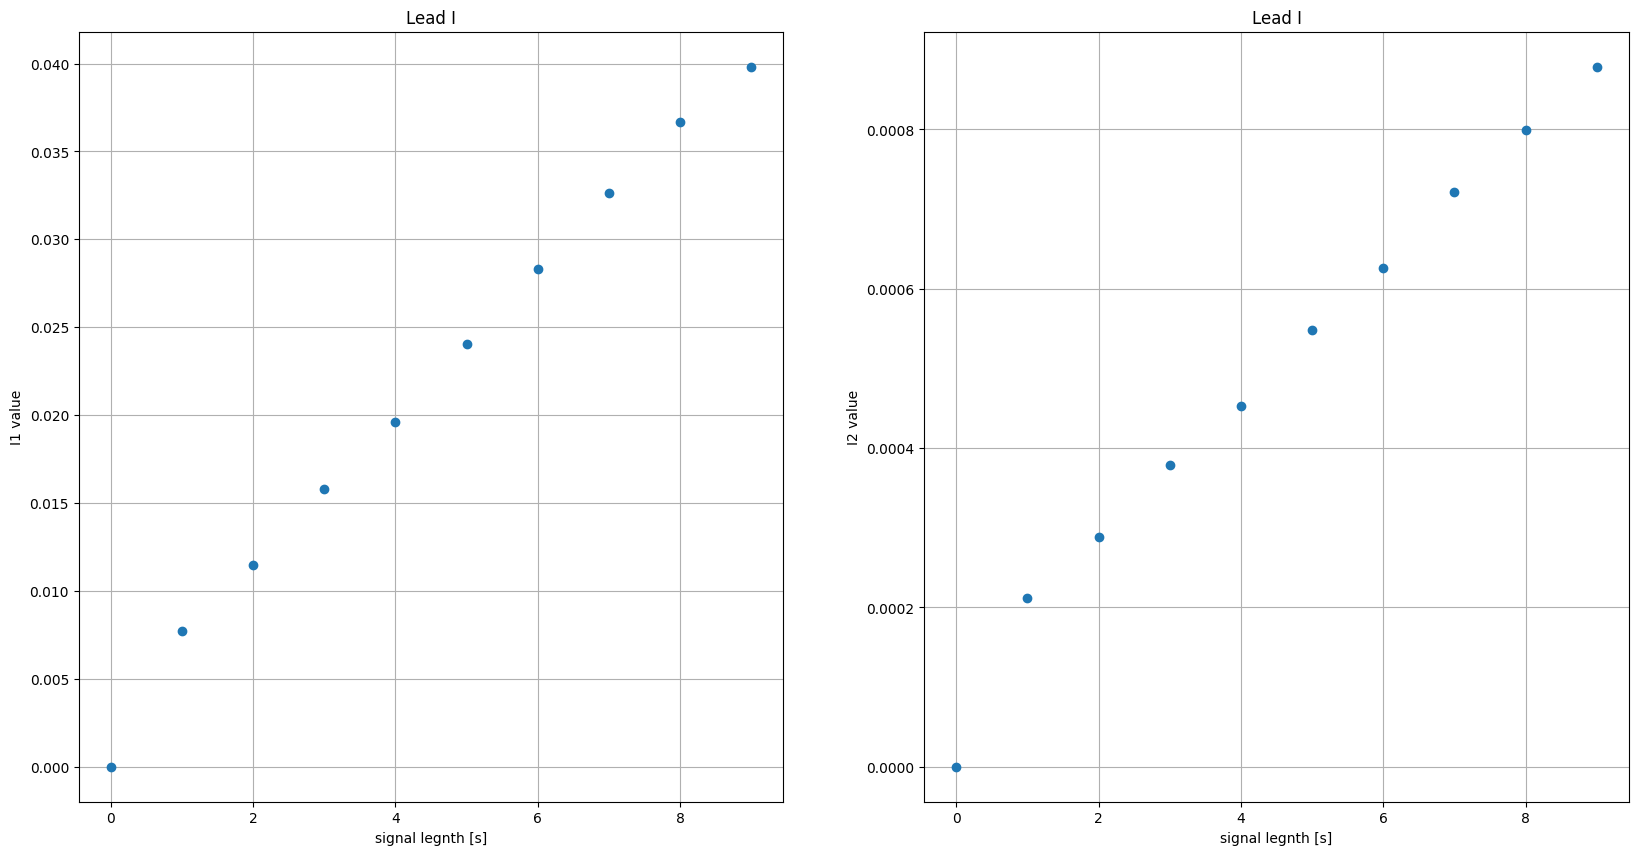

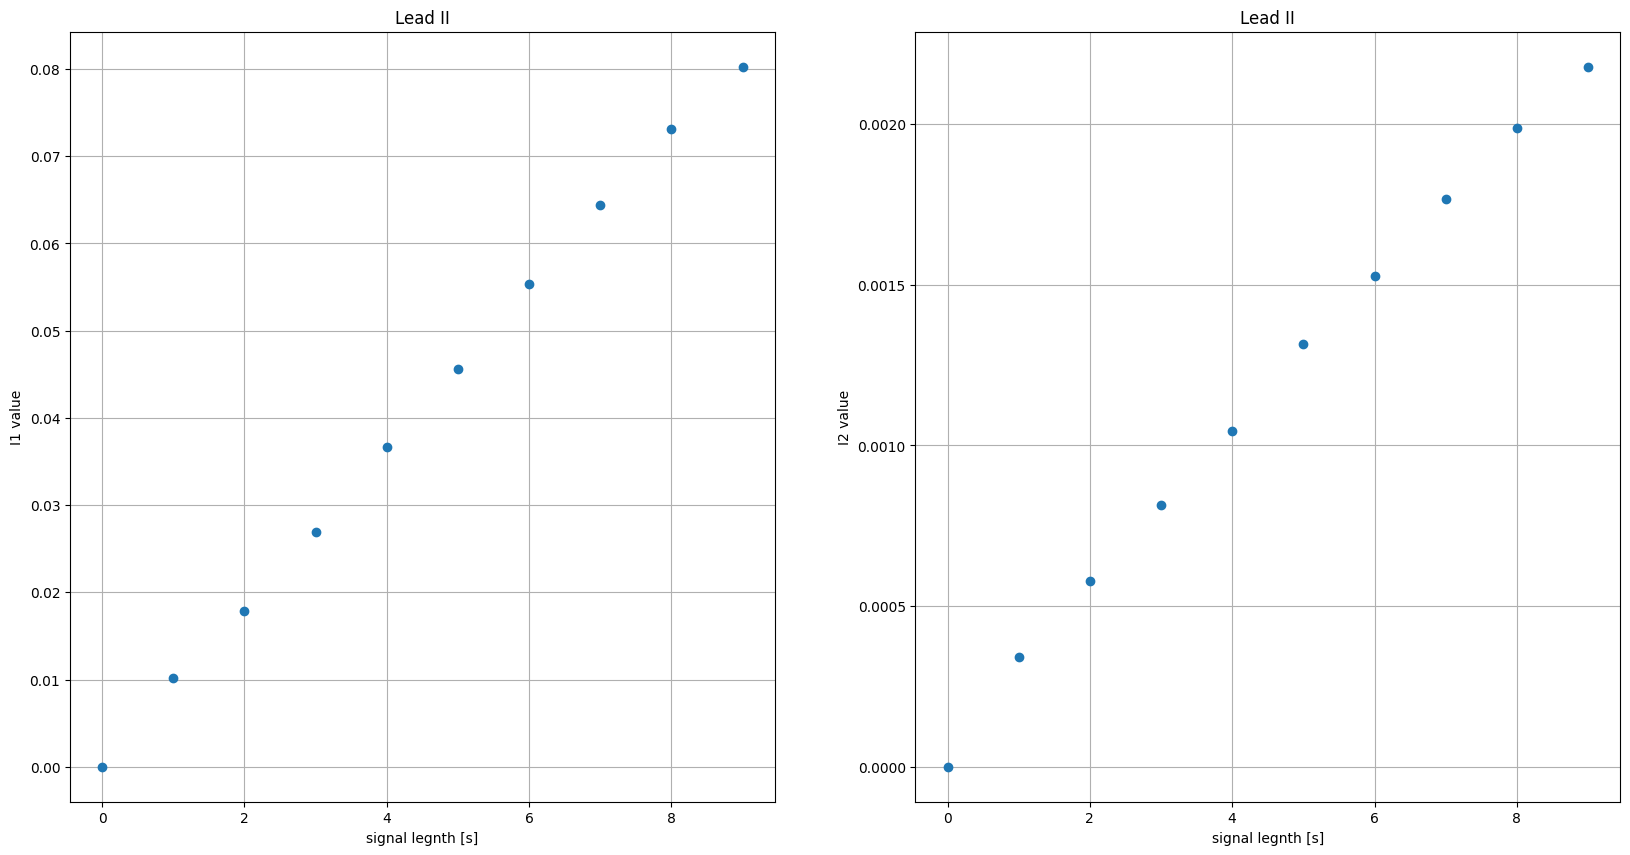

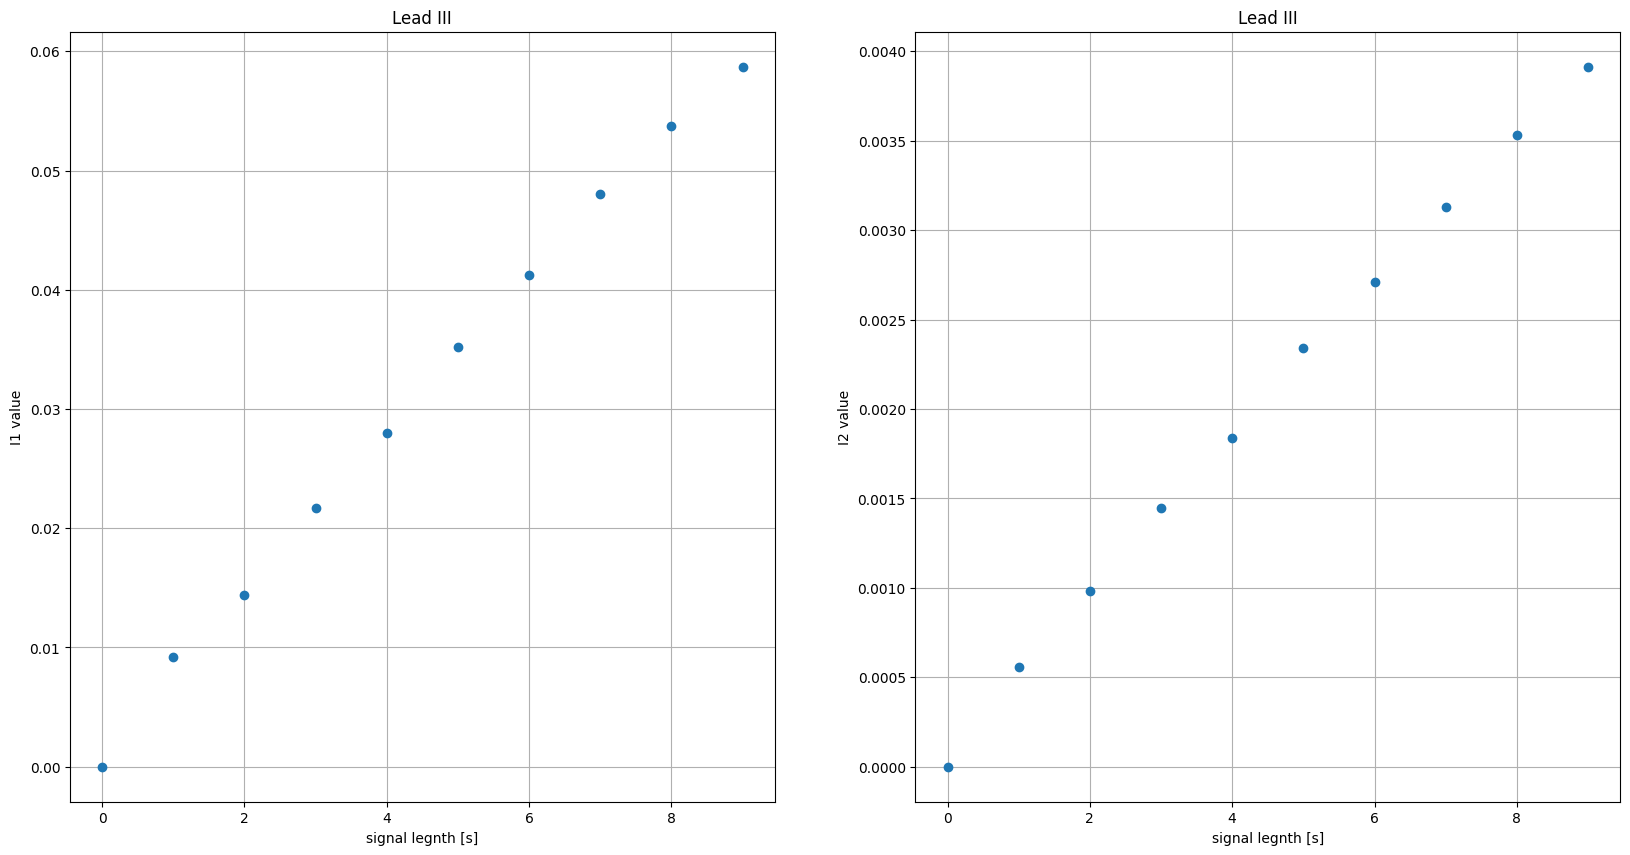

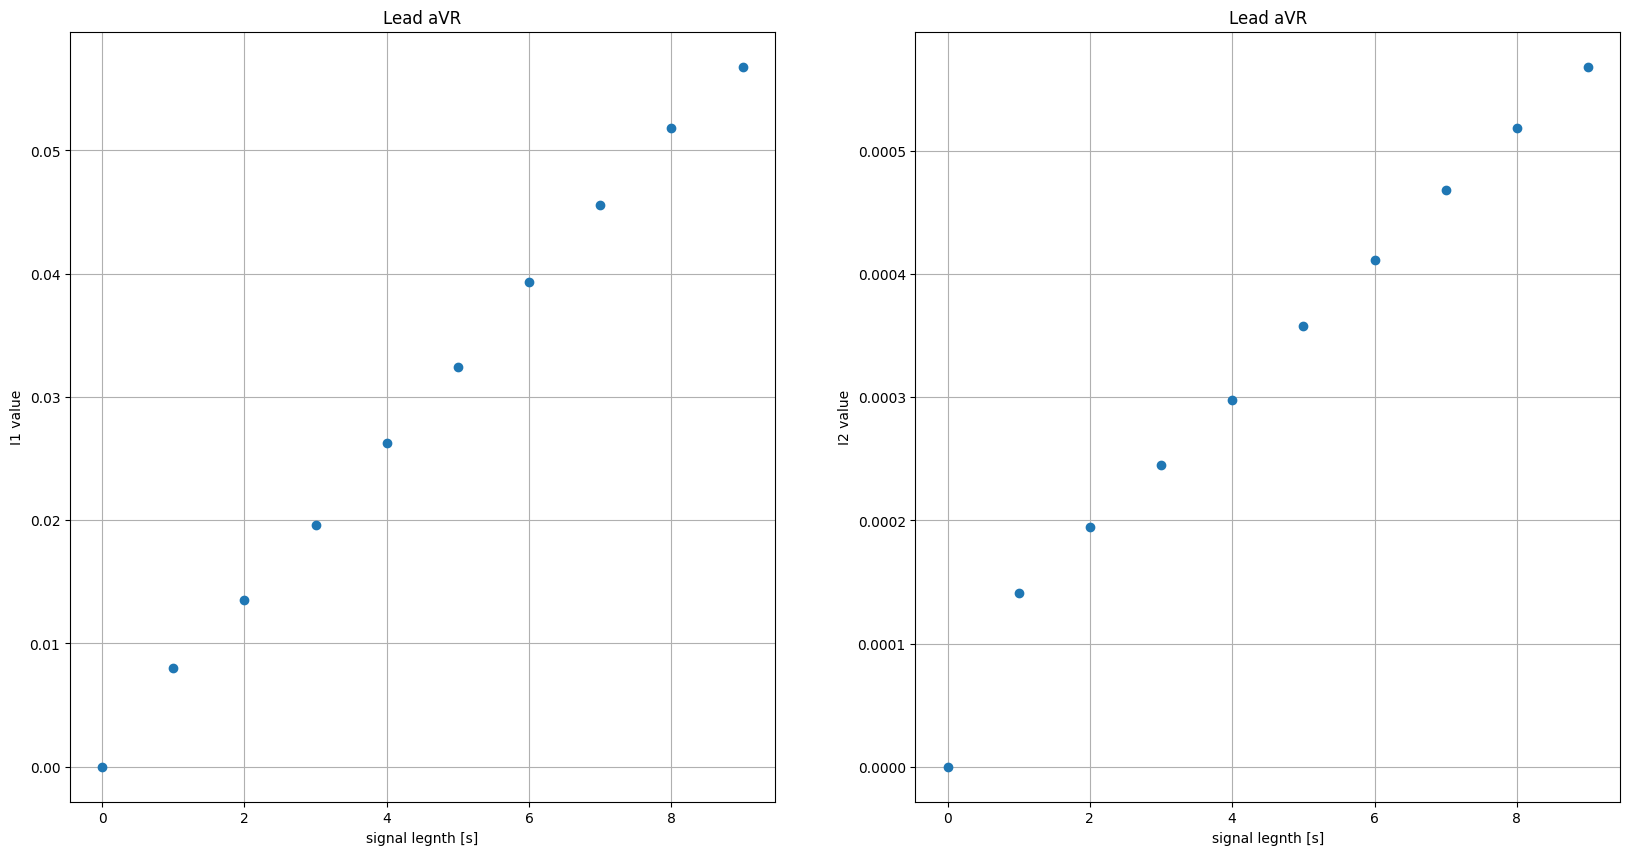

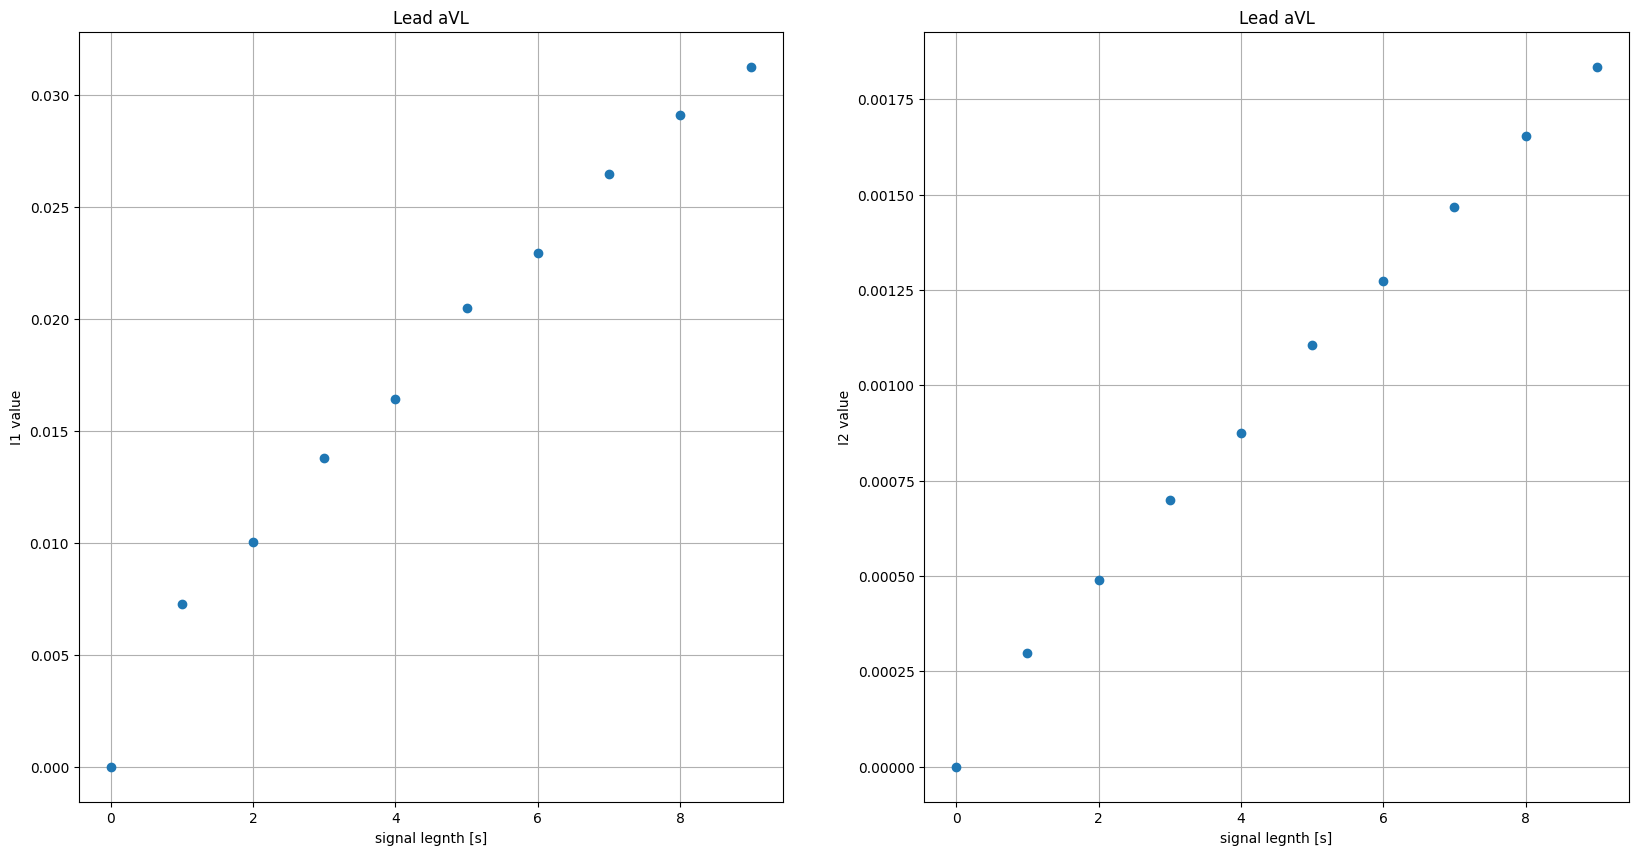

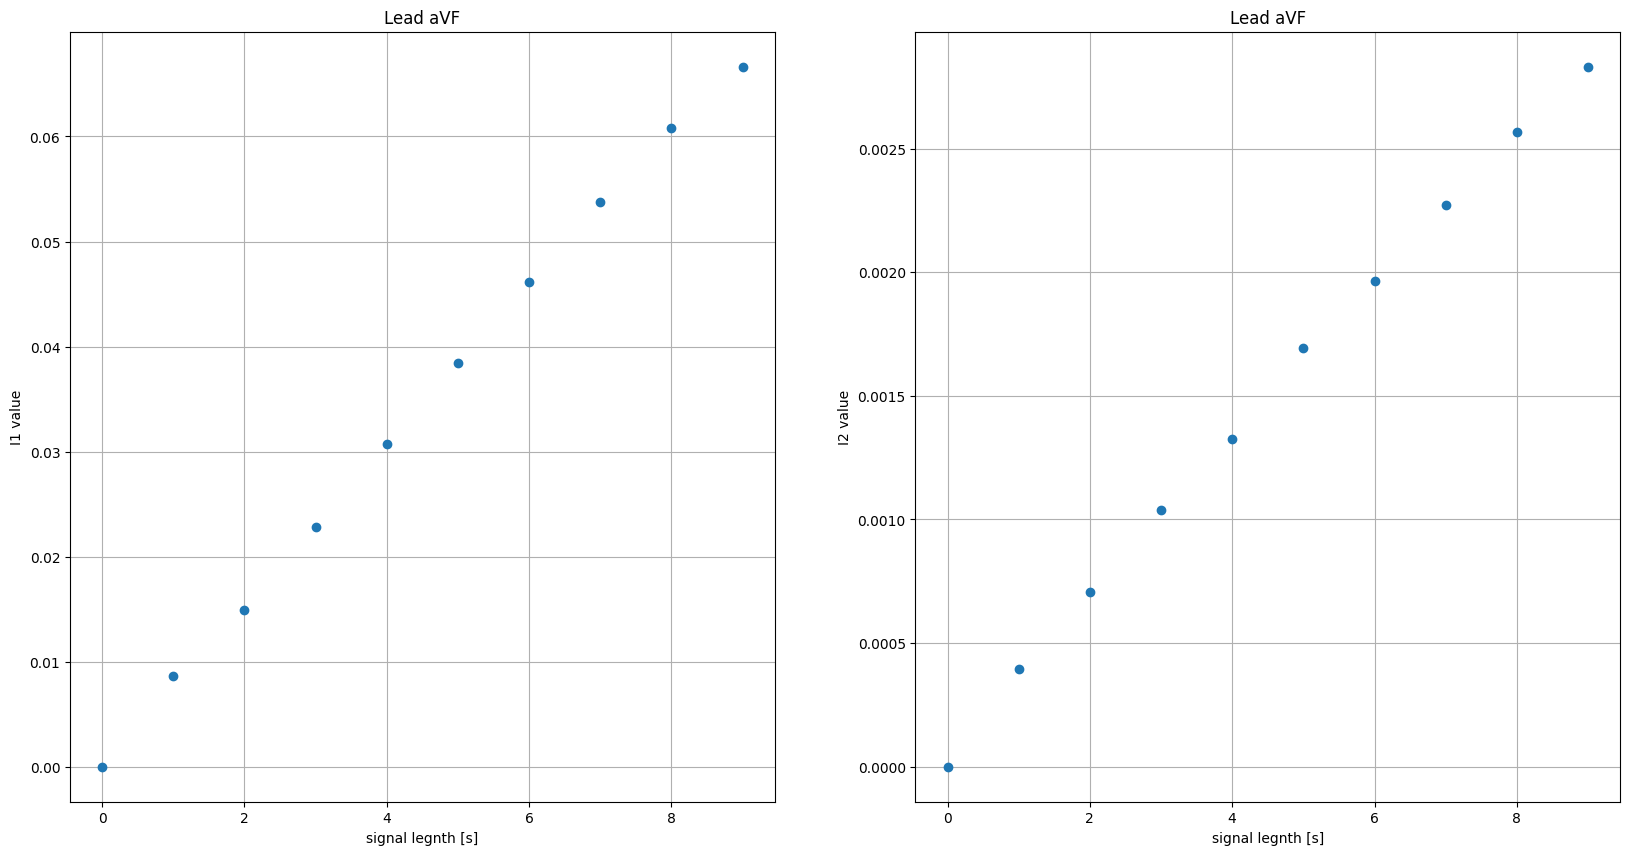

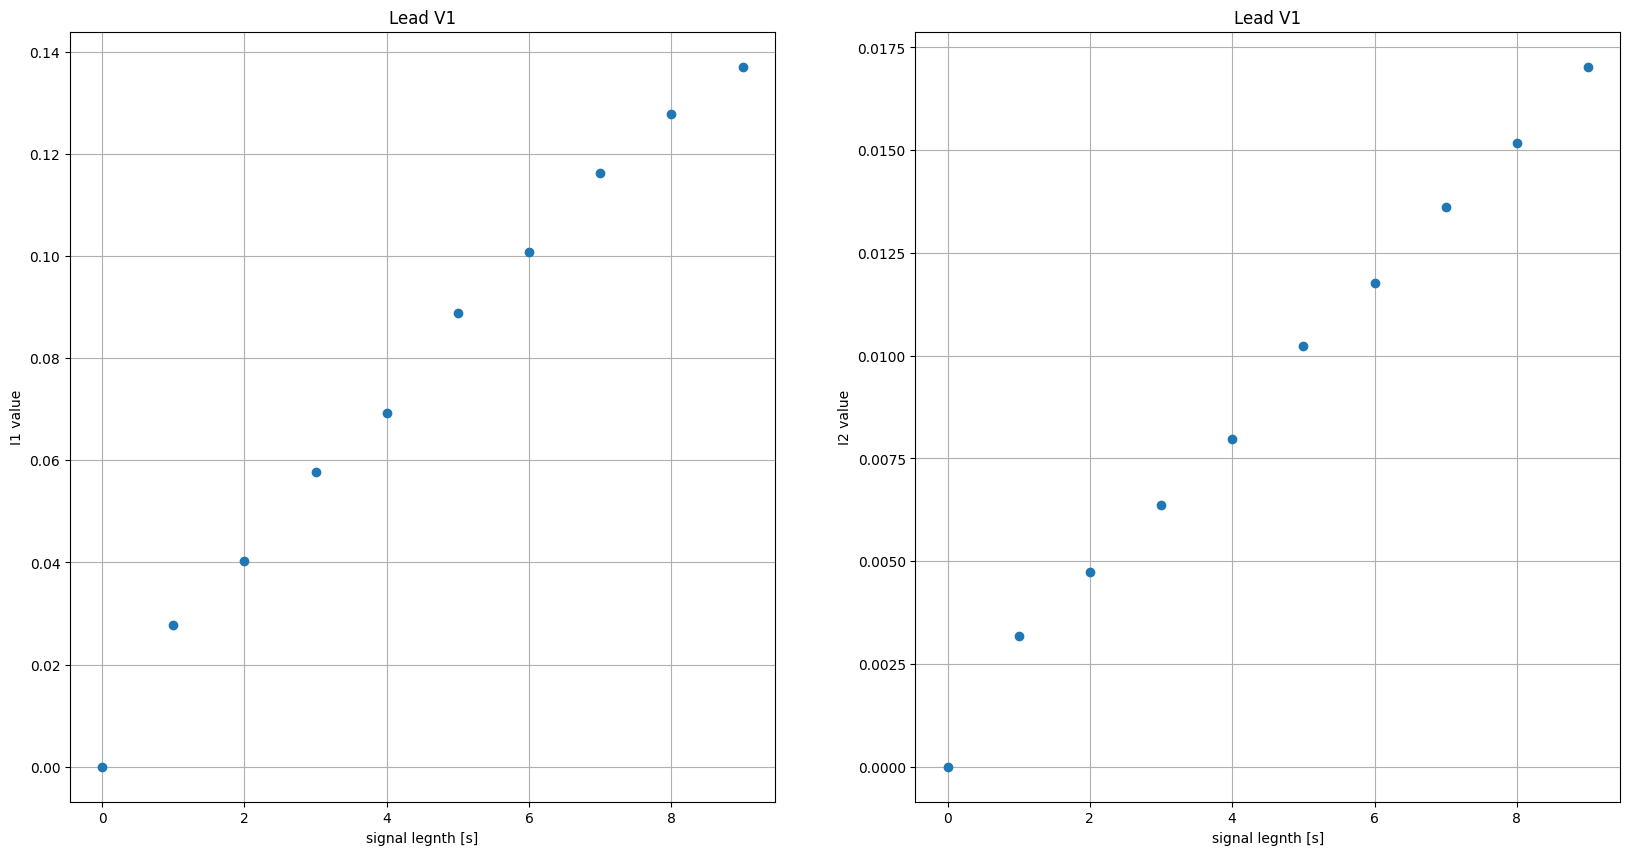

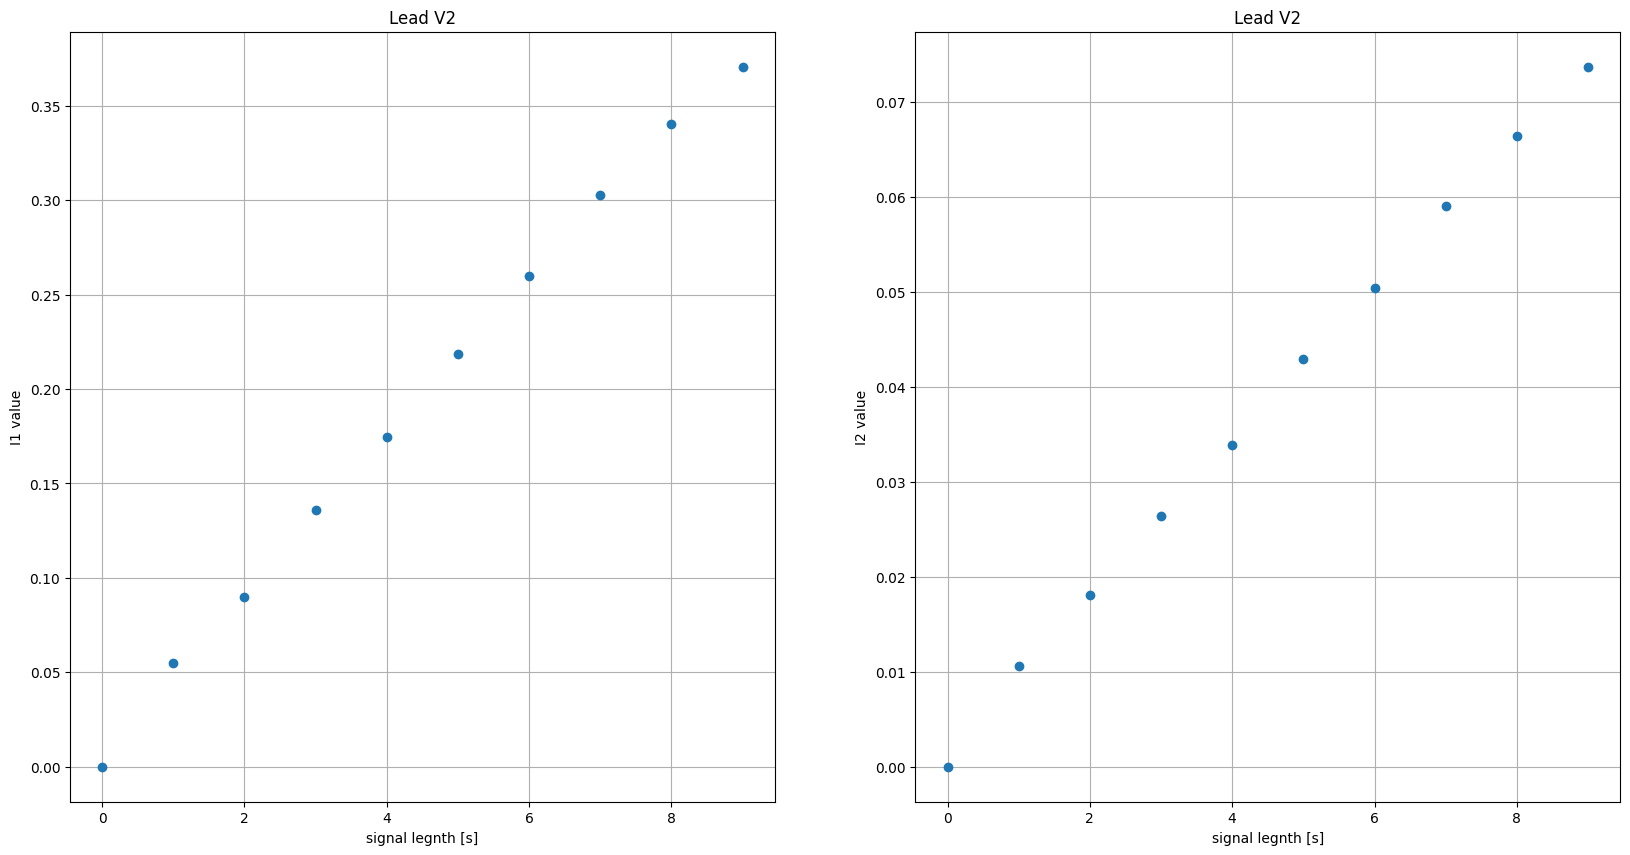

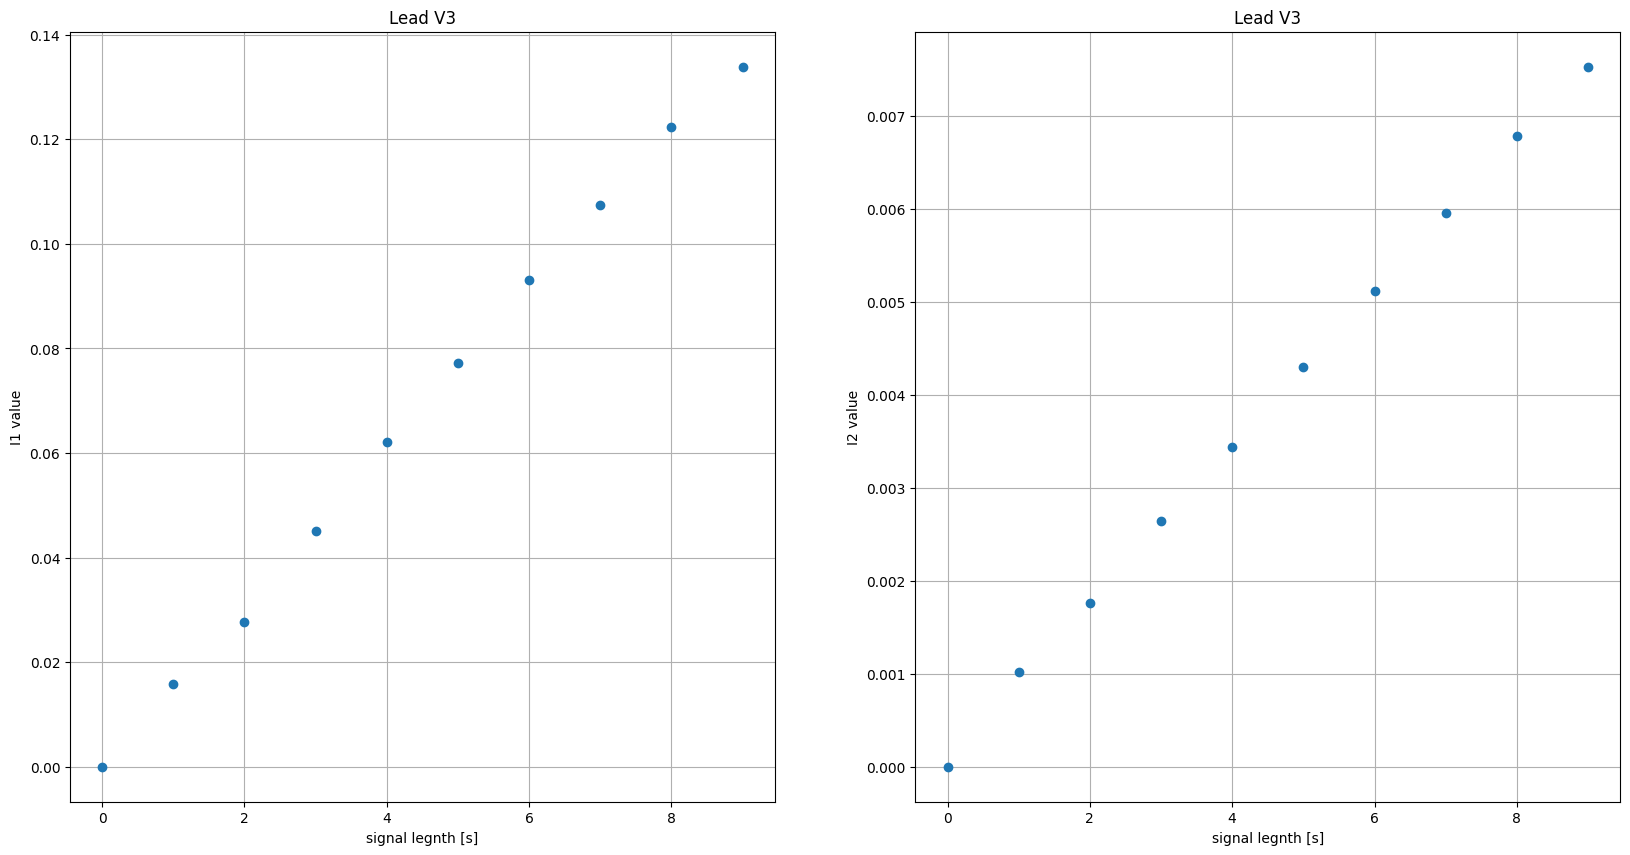

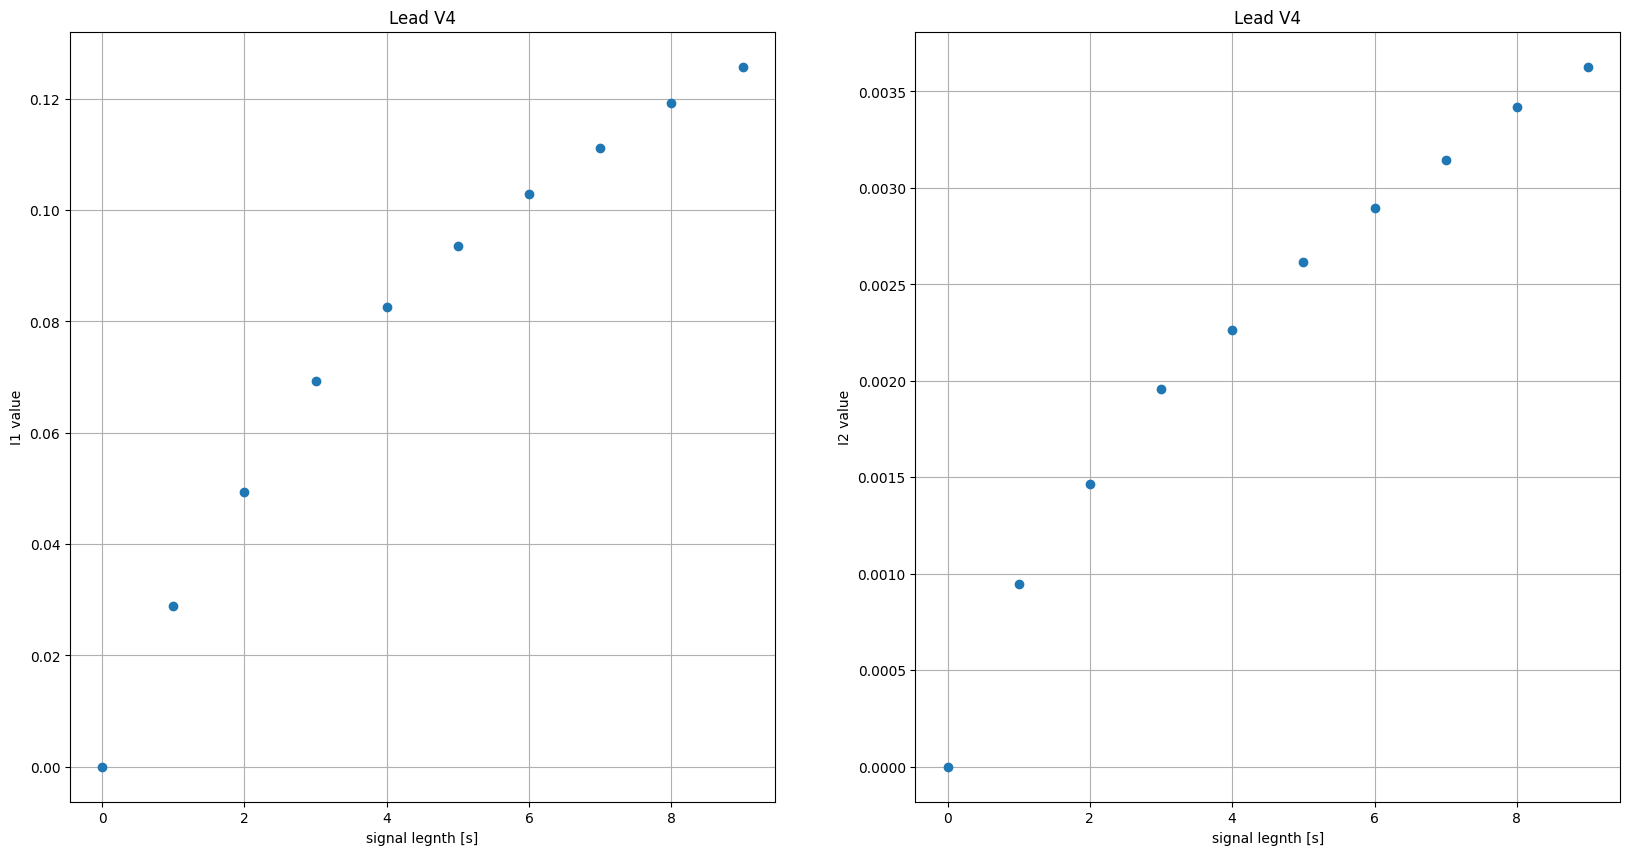

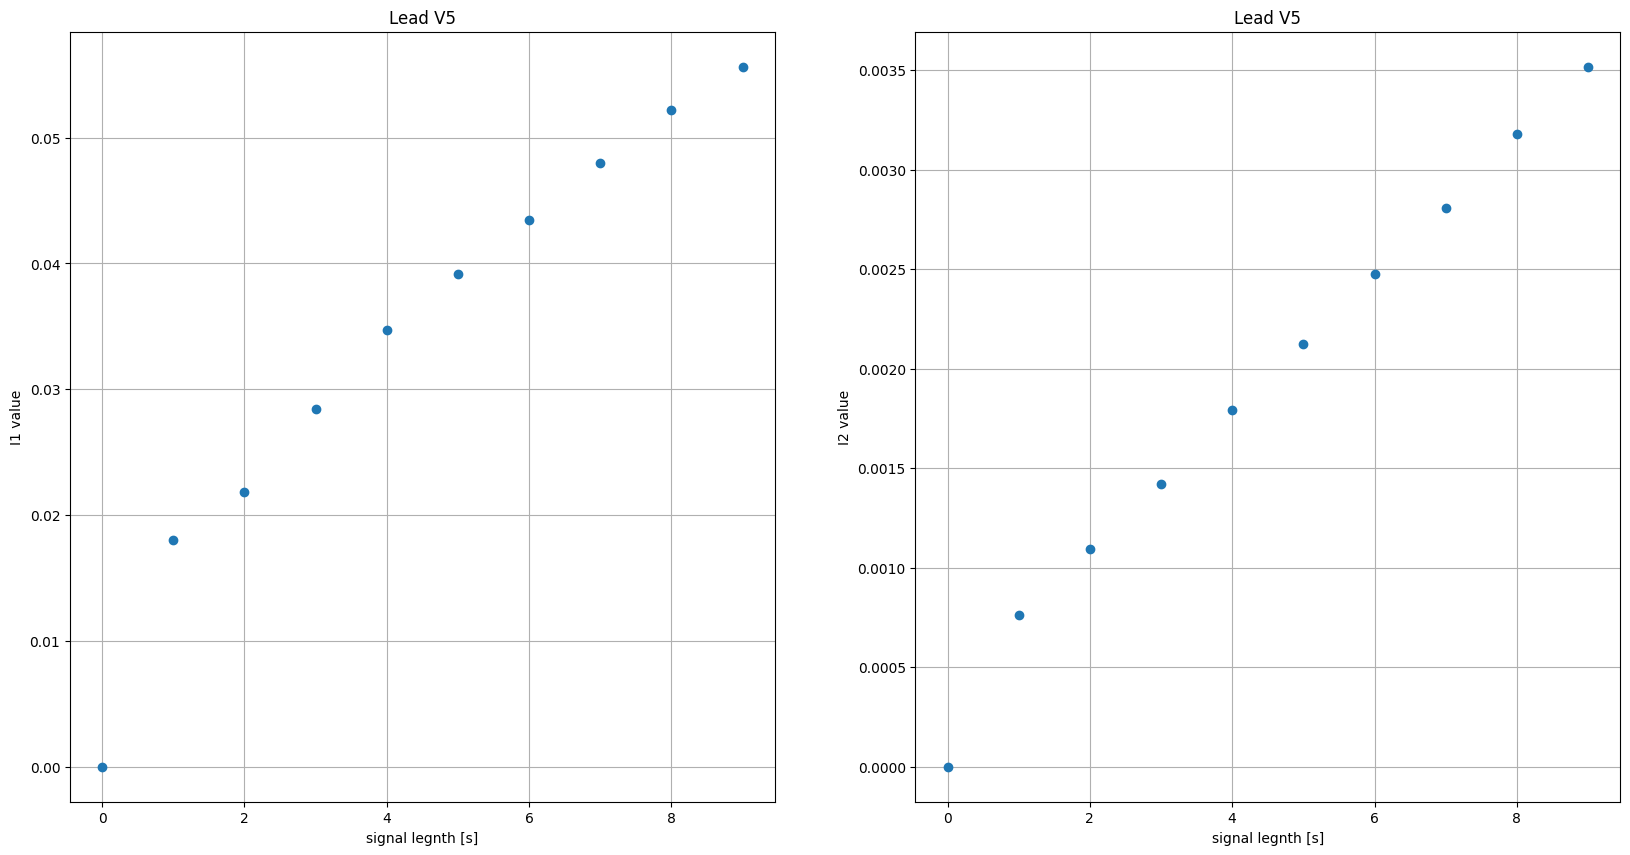

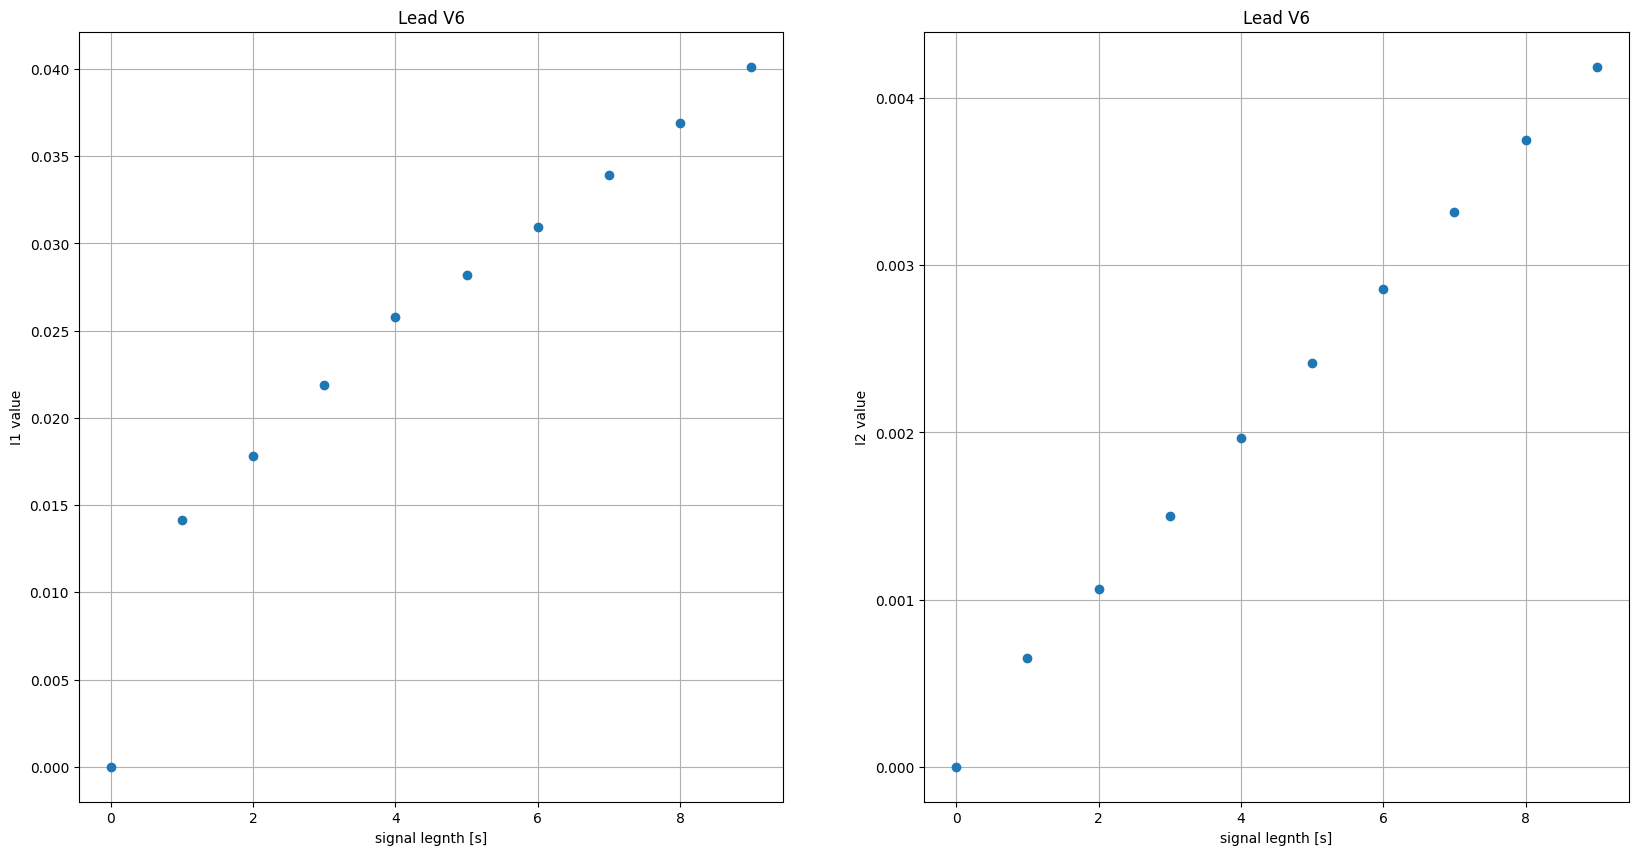

In [18]:
##Test function : 

h = 100
hprime = 1000
fs = data.sampling_frequency

for i in ECG_lead:
    I1_c,I2_c,c = discrepancies_mean_curve(dico_ECG[i],fs,h,hprime)
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
    ax[0].set_title(f"Lead {i.decode('utf8')}")
    ax[0].plot(c,I1_c,"o")
    ax[0].set_xlabel("signal legnth [s]")
    ax[0].set_ylabel("I1 value")
    ax[0].grid()
    ax[1].set_title(f"Lead {i.decode('utf8')}")
    ax[1].plot(c,I2_c,"o")
    ax[1].set_xlabel("signal legnth [s]")
    ax[1].set_ylabel("I2 value")
    ax[1].grid()
    


In [ ]:
###Implementation of Higuchi method 

def Lm_q(signal,m,k,fs=data.sampling_frequency):
    N = len(signal)
    n = np.floor((N-m)/k).astype(np.int64)
    norm  = ((N-1)/(n*k))/(k*(1/fs))
    sum = np.sum(np.abs(np.diff(signal[m::k], n=1)))
    Lmq = (sum*norm)
    return Lmq

def Lq_k(signal,k,fs=data.sampling_frequency):
    calc_L_series = np.frompyfunc(lambda m: Lm_q(signal,m,k,fs), 1, 1)
    L_average = np.average(calc_L_series(np.arange(1, k+1)))
    return L_average


def Dq(signal,kmax,fs=data.sampling_frequency):
    calc_L_average_series = np.frompyfunc(lambda k: Lq_k(signal,k,fs), 1, 1)

    k = np.arange(1, kmax+1)
    L = calc_L_average_series(k).astype(np.float64)

    D, _ = - np.polyfit(np.log2(k), np.log2(L), 1)

    return D




In [ ]:
##Trial and error for determining method for optimal signal length

Global_Dico = {}
Dico_dimension = {}
fs = data.sampling_frequency
for i in ECG_lead:
    signal_lead = dico_ECG[i]
    c = [i for i in range(1,int(len(signal_lead)/fs),1)]
    for boundary in c:
        j =1
        D = np.array([])
        while (j*boundary*fs)<=len(signal_lead):
            sig  = signal_lead[(j-1)*boundary*fs:(j)*boundary*fs]
            D = np.append(D,Dq(sig,20,fs))
            j+=1
        Dico_dimension[f"{boundary} sec"] = D
    Global_Dico[i] = Dico_dimension
    Dico_dimension = {}





[0.05742269 0.05814409 0.05849579 0.05930062 0.05654221 0.05632686
 0.05691113 0.05650723 0.05837017 0.05782775 0.05754499 0.05488608
 0.05490386 0.05540504 0.05624537 0.05664418 0.05719516 0.05717047
 0.0561076  0.05690851 0.05594325 0.05764161 0.05662556 0.05686506
 0.0564396  0.05696753 0.05667239 0.05609102 0.05654163 0.0568497
 0.0572295  0.05662221 0.05666297 0.05702617 0.0567817  0.05684074
 0.05745513 0.05681425 0.05656316 0.05594335 0.0570583  0.05681744
 0.05673631 0.05642101 0.05679491 0.05859426 0.05733238 0.05723938
 0.05789966 0.05829849 0.05626093 0.05619801 0.05659936 0.05753161
 0.05703207 0.05699418 0.05704221 0.05808855 0.05762228 0.05810886
 0.0587073  0.05587051 0.05655238 0.05647235 0.05716056 0.05828358
 0.057429   0.05684183 0.05858431 0.05675662 0.05819318 0.05787662
 0.05541262 0.05542811 0.05555467 0.05528939 0.05573322 0.05600381
 0.05615074 0.05649363 0.05669724 0.0567487  0.05614635 0.05629162
 0.05618094 0.05601979 0.05708388 0.05635274 0.05630332 0.05698

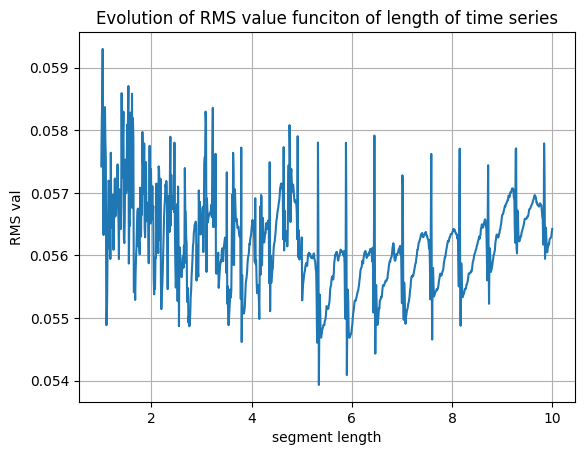

In [19]:
##RMS:

def RMS(tab_val):
    N = len(tab_val)
    square_sum =0
    for j in range(len(tab_val)):
        for i in range(j+1,len(tab_val)):
            square_sum += np.abs(tab_val[j]-tab_val[i])**2
    norm = 1/(N**2-N)
    rms_val = np.sqrt(norm*square_sum)
    return rms_val

h = 100
hprime = 1000
fs = data.sampling_frequency
c_axis = np.linspace(1,int(data.signal_length/fs),1000)

RMS_val = np.array([])
for j in c_axis:
    D = np.array([])
    for i in ECG_lead:
        w = 1
        Ds = np.array([])
        sig = dico_ECG[i]
        while (w*j*fs)<=len(sig):
            sig_c  = sig[int((w-1)*j*fs):int((w)*j*fs)]
            Ds = np.append(Ds,Dq(sig_c,20,fs))
            w+=1
        
        D = np.append(D,np.mean(Ds))
    RMS_val = np.append(RMS_val,RMS(D))

print(RMS_val) 
plt.plot(c_axis,RMS_val)
plt.title("Evolution of RMS value funciton of length of time series")
plt.xlabel("segment length")
plt.ylabel("RMS val")
plt.grid()
plt.show()

In [ ]:
##Graph comme proposer dans etude :

eps1 = np.linspace(1,9.5,100)
eps2 = np.linspace(0.01,0.095,100)
#c_axis = np.linspace(1,int(data.signal_length/fs),1000)
c_axis = {}

x,y = np.meshgrid(eps1,eps2)

for i in ECG_lead:
    sig = dico_ECG[i]
    I1_c,I2_c,c = discrepancies_mean_curve(sig,fs,h,hprime)
    f1 = np.polyfit(I1_c,c,1)
    f2 = np.polyfit(I2_c,c,1)
    l1 = np.poly1d(f1)
    l2 = np.poly1d(f2)
    c1 = l1(eps1)
    c2 = l2(eps2)
    c1x,c2y = np.meshgrid(c1,c2)
    print(c1x)
    z = np.empty((len(c1),len(c2)))
    for w in range(len(c1)):
        for j in range(len(c2)):
            z[w][j] = np.min(c1x[w][j],c2y[w][j])
    c_axis[i] = z

print(c_axis)
